**Цель блокнота** - показать связь между капитализацией и ликвидностью на российском рынке через пересечение позиций в портфелях. Распространенная точка зрения, что рыночная капитализация хорошо отражает ликвидность. Даже в индексе ММВБ-Мосбиржи больший вес дается более дорогим компаниям.

Каждый месяц мы будем разделять все доступные акции на 4 равных портфеля с разделением по капитализации. Первый портфель с наименьшей капитализацией включает в себя 0-25% акций из выборки. Промежуточные портфели с большей капитализацией 25-50% и 50-75%. Самые крупные компании будут находится в квантиле 75-100%. Абсолютное количество акций в периодах будет отличаться и зависит от количества листингованных бумаг и наличия данных. Полностью аналогичное построение портфелей проведем и для объема торгов в денежном выражении.

Построение портфелей решает две задачи - показывает экономический смысл системной покупки дешевых/дорогих компаний и позволяет посмотреть пересечение позиций через подсобную таблицу .holdings

Полученные результаты по России (ММВБ + Мосбиржа) сравним со взаимосвязью ликвидности-капитализации на рынке США (NYSE+NASDAQ)

**Disclaimer:** точнее будет считать капитализацию доли акций в свободном обращении, но таких данных пока нет, поэтому возьмем капитализацию всего бизнеса на каждый месяц.

# 1 - Импортируем библиотеки

In [1]:
import pqr

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)

pqr - 0.4.1

pandas - 1.3.0

numpy - 1.21.0

matplotlib - 3.4.2

# 2 - Загружаем и обрабатываем данные по России

In [2]:
import os; os.chdir("..")
os.chdir('C:/Users/tomtosov/Desktop/countries_data_new/countries_data/factors/csv/russia')

Загружаем данные, объем переводим из тыс. акций в рубли (грубо по цене закрытия):

In [3]:
prices = pd.read_csv("close_price.csv", parse_dates=True, index_col=0)["2003":]
volume = pd.read_csv("trading_volume.csv", parse_dates=True, index_col=0)["2003":]
volume = prices * volume * 1000

mcap = pd.read_csv("mcap.csv", parse_dates=True, index_col=0)["2003":]

Далее два технических шага:

1) Заменяем 0 на NaN. В некоторые периоды отстутствующие котировки в моих данных выставлены как 0. Понятно, что 0 цен на покупку/продажу не бывает и это отсутствующее значение, которое нужно заменить на NaN.

2) Приравниваем матрицы - обычно по ценам больший охват данных, чем по прочим. Если уверены, что матрицы одного размера, то этот шаг можно пропустить.

In [4]:
prices, mcap, volume = pqr.utils.replace_with_nan(prices, mcap, volume, to_replace=0)
prices, mcap, volume = pqr.utils.align(prices, mcap, volume) 

Размерность всех таблиц совпадает

In [5]:
prices.shape,  mcap.shape, volume.shape

((224, 364), (224, 364), (224, 364))

Таблицы с данными для pqr должны быть единого размера. По горизонтальной оси - названия инструментов, по вертикальной - индекс дат. В ячейках - значение целевого показателя. Одна таблица .xlsx или .csv - один показатель. Множество листов в MS Excel лучше не использовать. Пример таблицы:

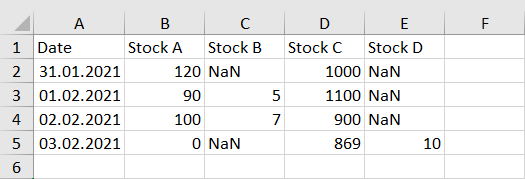

# 3 - Выставляем stock universe, загружаем внешний бенчмарк

Наш stock universe будет включать в себя почти все доступные акции. Минимальный фильтр в 1_000_000 рублей объема торгов за месяц обрезает бумаги, которые невозможно купить. Остальные неликвиды будут скорректированы тем, что веса мы зададим по капитализации и их роль не будет выше Газпромов и Сбербанков:

In [30]:
rus_universe = volume > 1_000_000

Отслеживаем доходность по ценам закрытия

In [31]:
returns_calculator = pqr.utils.partial(
    pqr.calculate_returns, 
    universe_returns=pqr.prices_to_returns(prices),
)

Индекс ММВБ за тот же период загружаем и используем как бенчмарк. В качестве внешнего бенчмарка важно задать именно pandas.Series, а не pandas.DataFrame

In [32]:
imoex = pd.read_excel('C:/Users/tomtosov/Desktop/imoex.xlsx', index_col=0, parse_dates=True)['MOEX RUSSIA INDEX - PRICE INDEX']['2003':]

imoex_benchmark = pqr.Benchmark.from_index(
    index=imoex,
    name='IMOEX'
)

In [33]:
imoex

IMOEX
2003-01-31     307.78
2003-02-28     341.52
2003-03-31     325.56
2003-04-30     369.77
2003-05-30     421.08
               ...   
2021-04-30    3544.00
2021-05-31    3721.63
2021-06-30    3841.85
2021-07-30    3771.58
2021-08-31    3918.96
Name: MOEX RUSSIA INDEX - PRICE INDEX, Length: 224, dtype: float64

# 4 - Создаем Dashboard с метриками для портфелей

Аннулиазируем и умножаем на 100 для удобства будущей визуализации

In [34]:
rus_table = pqr.metrics.Table()

rus_table.add_metric(
    pqr.utils.partial(
        pqr.metrics.mean_return,
        statistics=True,
        annualizer=12,
    ),
    multiplier=100,
    name="Monthly Mean Return, %",
)

rus_table.add_metric(
    pqr.utils.partial(
        pqr.metrics.cagr,
        annualizer=12,
    ),
    multiplier=100,
    name="CAGR, %",
)

rus_table.add_metric(
    pqr.utils.partial(
        pqr.metrics.volatility,
        annualizer=12,
    ),
    multiplier=100,
    name="Monthly Volatility, %",
)

rus_table.add_metric(
    pqr.utils.partial(
        pqr.metrics.sharpe_ratio,
        annualizer=12,
    ),
    name="Sharpe Ratio, %",
)

rus_table.add_metric(
    pqr.utils.partial(
        pqr.metrics.total_return,
    ),
    multiplier=100,
    name="Total Return, %",
)

rus_table.add_metric(
    pqr.utils.partial(
        pqr.metrics.alpha,
        statistics=True,
        benchmark=imoex_benchmark,
        annualizer=12,
    ),
    multiplier=100,
    name="Alpha, %",
)

rus_table.add_metric(
    pqr.utils.partial(
        pqr.metrics.beta,
        benchmark=imoex_benchmark,
    ),
    name="Beta",
)

rus_table.add_metric(
    pqr.utils.partial(
        pqr.metrics.benchmark_correlation,
        benchmark=imoex_benchmark,
    ),
    name="Benchmark Correlation",
)

rus_table.add_metric(
    pqr.utils.partial(
        pqr.metrics.mean_turnover,
        annualizer=12,
    ),
    multiplier=100,
    name="Mean Turnover, %",
)

rus_table.add_metric(
    pqr.utils.partial(
        pqr.metrics.win_rate,
    ),
    multiplier=100,
    name="Win Rate, %",
)
    
rus_table.add_metric(
    pqr.utils.partial(
        pqr.metrics.max_drawdown,
    ),
    multiplier=100,
    name="Max Drawdown, %",
)

Шаблон графика накопленной доходности

In [35]:
rus_fig = pqr.metrics.Figure(
    pqr.metrics.compounded_returns,
    name="Compounded Returns",
    benchmark=imoex_benchmark,
    log_scale=False,
)

Дэшборд из таблицы с метриками и графика

In [36]:
rus_summary = pqr.metrics.Dashboard([rus_table, rus_fig])

# 5 - Создаем факторы для принятия решений. Это рыночная капитализация и объем торгов

Отбираем бумаги (создаем фактор) на основе данных предыдущего периода с задержкой 1 месяц, держать портфели будем также 1 месяц:

In [37]:
static_params = pqr.utils.compose(
    pqr.utils.partial(pqr.factors.filter, universe=rus_universe),
    pqr.utils.partial(pqr.factors.look_back_mean, period=0),
    pqr.utils.partial(pqr.factors.lag, period=1), 
    pqr.utils.partial(pqr.factors.hold, period=1), 
)

In [38]:
rus_size_factor = static_params(mcap)
rus_volume_factor = static_params(volume)

# 6 - Создаем портфели

Создаем портфели по рыночной капитализации. Losers это портфель с самыми дешевыми (от 0 до 25%) компаниями на каждый месяц. Winners (75-100%) - самые дорогие. Neutral 1 и 2 - промежуточные варианты. Все портфели одинаковы по количеству акций в одном периоде.  Веса в портфелях по капитализации

,Winners,Neutral 1,Neutral 2,Losers
"Monthly Mean Return, %",16.29*** (2.90),15.15*** (2.58),21.51*** (3.46),25.35*** (3.24)
"CAGR, %",14.15,12.44,19.50,22.15
"Monthly Volatility, %",24.23,25.27,26.79,33.70
"Sharpe Ratio, %",0.67,0.60,0.80,0.75
"Total Return, %",1069.73,784.30,2638.50,4016.02
"Alpha, %",0.32 (0.20),1.09 (0.31),7.72* (1.83),12.30* (1.86)
Beta,0.95,0.84,0.82,0.78
Benchmark Correlation,0.96,0.81,0.75,0.56
"Mean Turnover, %",86.27,380.17,537.89,834.85
"Win Rate, %",63.23,58.74,56.50,53.81


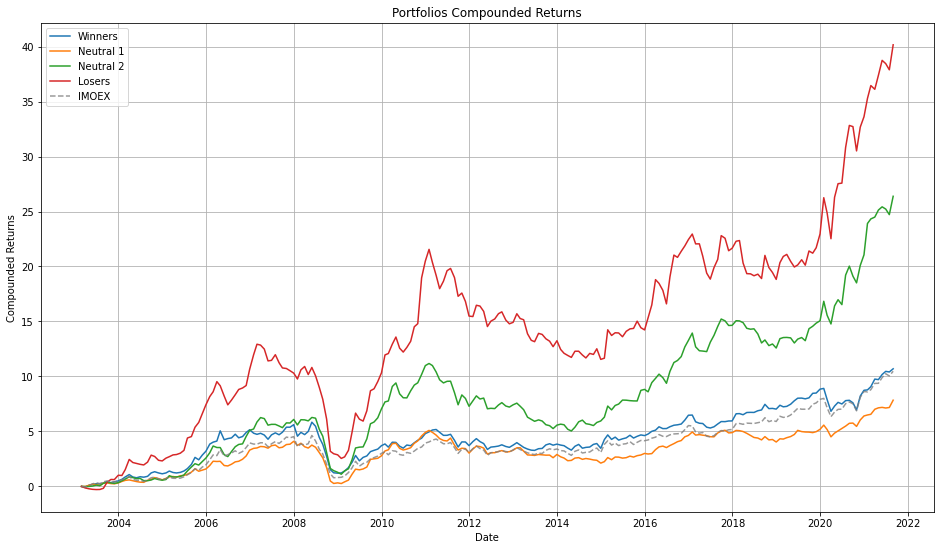

In [39]:
rus_size_portfolios = pqr.factors.backtest_factor_portfolios(
    factor=rus_size_factor,
    strategies=pqr.factors.split_quantiles(4, better='more'), 
    allocator=pqr.utils.compose(
        pqr.utils.partial( 
            pqr.normalized_weights, 
            base_weights=size_factor 
        ),
    ),        
    calculator=returns_calculator, 
    add_wml=False, 
)

rus_summary.display(rus_size_portfolios)

На первый взгляд все логично: портфели с малыми акциями более рискованны (Волатильность, максимальная просадка, винрейт), но и более доходны. У портфеля нереалистично высокая оборачиваемость. Если состав 25% наиболее дорогих компаний обновляется менее, чем на 100% в год, то малые компании обновляются почти каждый месяц.

Аналогично создаем портфели по объему торгов:

,Winners,Neutral 1,Neutral 2,Losers
"Monthly Mean Return, %",17.32*** (3.04),12.18** (2.00),15.27*** (2.71),14.66** (2.32)
"CAGR, %",15.24,8.84,13.01,11.49
"Monthly Volatility, %",24.54,26.28,24.30,27.20
"Sharpe Ratio, %",0.71,0.46,0.63,0.54
"Total Return, %",1295.07,382.57,871.22,655.02
"Alpha, %",1.26 (0.71),-2.26 (-0.60),3.14 (0.79),3.35 (0.65)
Beta,0.96,0.86,0.72,0.67
Benchmark Correlation,0.95,0.80,0.73,0.60
"Mean Turnover, %",110.85,843.33,1223.76,1320.08
"Win Rate, %",63.68,60.54,58.74,55.16


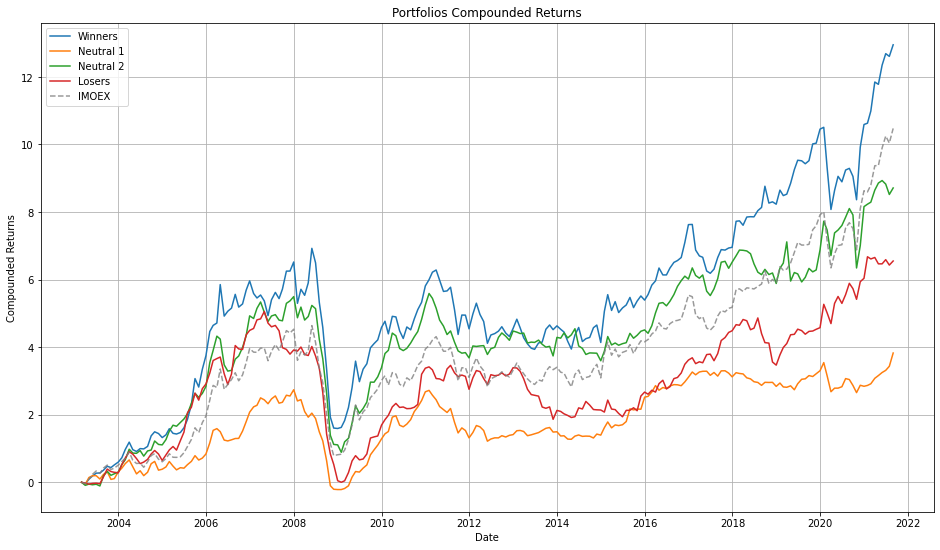

In [40]:
rus_volume_portfolios = pqr.factors.backtest_factor_portfolios(
    factor=rus_volume_factor, 
    strategies=pqr.factors.split_quantiles(4, better='more'), 
    allocator=pqr.utils.compose(
        pqr.utils.partial( 
            pqr.normalized_weights,
            base_weights=rus_size_factor 
        ),
    ),        
    calculator=returns_calculator, 
    add_wml=False, 
)

rus_summary.display(rus_volume_portfolios)

С объемом некоторый парадокс - наиболее ликвидные акции одновременно дали большую доходность и меньший риск

# 7 - Смотрим состав портфелей подробнее и находим пересечения позиций

In [41]:
rus_volume_portfolios

[Portfolio(name='Winners'),
 Portfolio(name='Neutral 1'),
 Portfolio(name='Neutral 2'),
 Portfolio(name='Losers')]

Количество бумаг в одном из портфелей на каждый период

In [42]:
(rus_size_portfolios[0].holdings >0).sum(axis=1)

Winners
2003-02-28     6
2003-03-31     6
2003-04-30     6
2003-05-30     6
2003-06-30     6
              ..
2021-04-30    46
2021-05-31    47
2021-06-30    46
2021-07-30    45
2021-08-31    44
Length: 223, dtype: int64

In [43]:
(rus_volume_portfolios[0].holdings >0).sum(axis=1)

Winners
2003-02-28     6
2003-03-31     6
2003-04-30     6
2003-05-30     6
2003-06-30     6
              ..
2021-04-30    46
2021-05-31    47
2021-06-30    46
2021-07-30    45
2021-08-31    44
Length: 223, dtype: int64

Найдем пересечение портфелей по составу. Совпадение весов неважно, оно зависит от других бумаг и почти никогда не совпадает. Поэтому смотрим только наличие (1) и отсутствие (0)

In [44]:
high_volume = rus_volume_portfolios[0].holdings.copy()
high_volume[high_volume>0] = 1

high_mcap = rus_size_portfolios[0].holdings.copy()
high_mcap[high_mcap>0] = 1

0.73


<AxesSubplot:xlabel='Winners'>

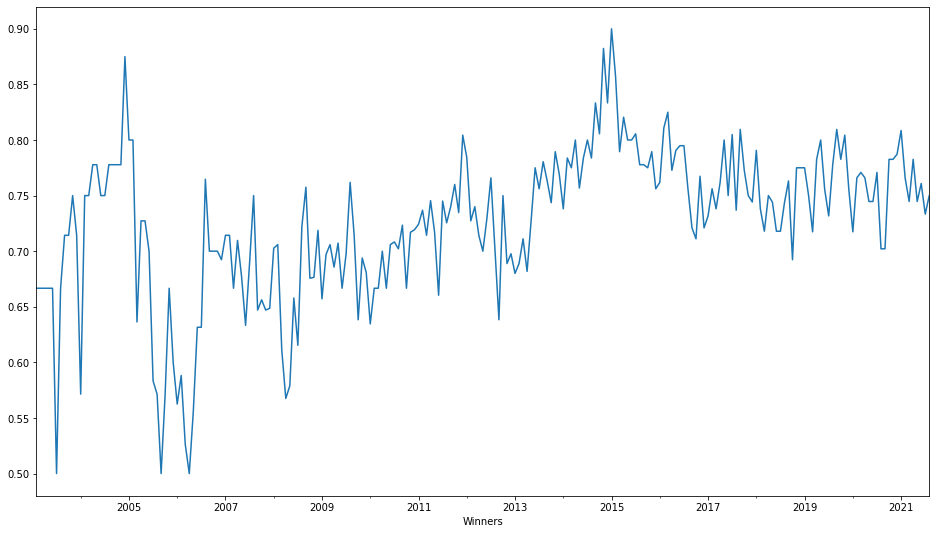

In [45]:
high_intersections = high_volume + high_mcap
high_intersections[high_intersections<2] = 0
high_intersections[high_intersections==2] = 1
high_intersections_share = high_intersections.sum(axis=1) / (rus_volume_portfolios[0].holdings >0).sum(axis=1)
print(round(high_intersections_share.mean(), 2))
high_intersections_share.plot()

**В итоге, топ 25% самых крупных и 25% ликвидных по объему торгов совпадают по составу только на 73%. В ранние годы ситуация была еще хуже и доходила до 50%**

Повторим аналогичные расчеты для 25% наименее ликвидных и дешевых бумаг 

0.54


<AxesSubplot:xlabel='Losers'>

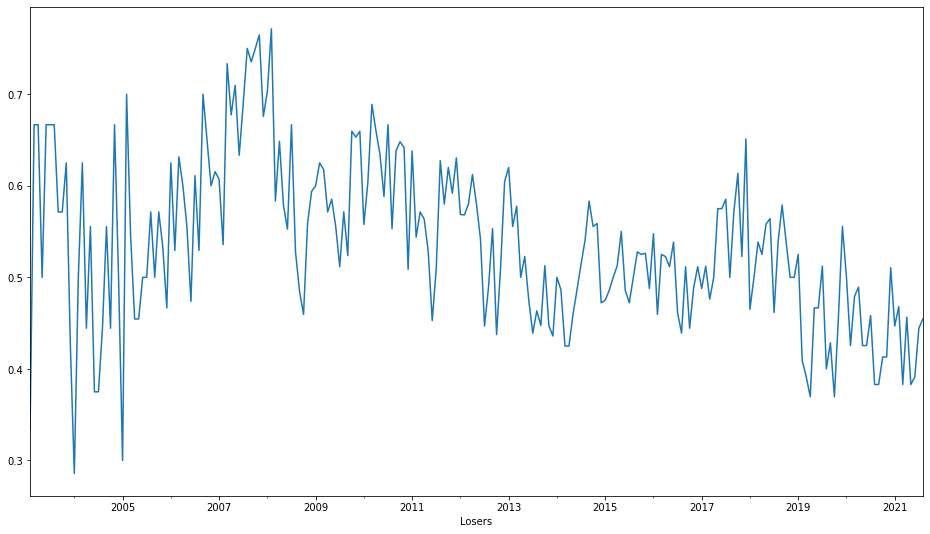

In [63]:
low_volume = rus_volume_portfolios[-1].holdings.copy()
low_volume[low_volume>0] = 1

low_mcap = rus_size_portfolios[-1].holdings.copy()
low_mcap[low_mcap>0] = 1

low_intersections = low_volume + low_mcap
low_intersections[low_intersections<2] = 0
low_intersections[low_intersections==2] = 1
low_intersections_share = low_intersections.sum(axis=1) / (rus_volume_portfolios[-1].holdings >0).sum(axis=1)
print(round(low_intersections_share.mean(), 2))
low_intersections_share.plot()

Закономерно с учетом увиденной ранее оборачиваемости портфелей. Интересно, что тут ситуация практически не изменилась с 2003г.

Количество месяцев, когда пересечение портфелей составляло менее 50%

In [64]:
(low_intersections_share<0.5).sum()

72

Объем топ-50 позиций по количеству месяцев с попадаем в портфель

In [48]:
(rus_volume_portfolios[0].holdings>0).sum(axis=0).sort_values(ascending=False).head(50)

MMC NORILSK NICKEL          223
ROSTELECOM                  223
GAZPROM                     223
NK LUKOIL                   223
SBERBANK OF RUSSIA          220
SURGUTNEFTEGAS              216
TATNEFT                     211
GAZPROM NEFT                200
MOBILE TELESYSTEMS          190
MOSENERGO                   184
SEVERSTAL                   183
OC ROSNEFT                  181
NOVATEK                     175
MAGNITOGORSK IOSTL.WORKS    173
AEROFLOT RUSS.AIRL.         173
NOVOLIPETSK STEEL           170
VTB BANK                    167
YUNIPRO                     159
FED.HYGN.CO. RUSHYDRO       159
RASPADSKAYA                 159
FSK YEES                    157
INTER RAO EES               156
MAGNIT                      152
MECHEL OAO                  148
SISTEMA JSFC                148
POLYUS                      148
ROSSETI                     147
OGK-2                       138
URALKALI                    128
PIK GROUP                   120
ALROSA                      118
ANK BASH

Капитализация топ-50

In [49]:
(rus_size_portfolios[0].holdings>0).sum(axis=0).sort_values(ascending=False).head(50)

NK LUKOIL                    223
GAZPROM                      223
GAZPROM NEFT                 223
SURGUTNEFTEGAS               223
MMC NORILSK NICKEL           223
SBERBANK OF RUSSIA           223
MOBILE TELESYSTEMS           214
TATNEFT                      213
NOVATEK                      199
SEVERSTAL                    194
MAGNITOGORSK IOSTL.WORKS     187
NOVOLIPETSK STEEL            184
POLYUS                       183
OC ROSNEFT                   181
ROSTELECOM                   180
VTB BANK                     168
YUNIPRO                      164
FED.HYGN.CO. RUSHYDRO        159
MAGNIT                       158
SISTEMA JSFC                 155
FSK YEES                     155
ANK BASHNEFT                 153
ROSSETI                      151
INTER RAO EES                148
URALKALI                     143
VSMPO                        123
MOSENERGO                    123
PHOSAGRO                     121
ALROSA                       120
NVYSK.COML.SEA PORT          118
ROSBANK   

Интересно посмотреть в отдельности акции, которые пересекались между двумя портфелями меньше всего. Предварительно - там все не очень хорошо с точки зрения рисков для инвесторов и возможностей для манипуляций.

1) Визуально, к компаниям с огромной капитилазацией низким объемом торгов можно отнести финансовые холдинги (Открытие, Росгосстрах), порты и оборонные заводы. Уралкалий, ультра блючип 2000-х и первой половины 2010-х, почти на 20% чаще представлен mcap в портфеле, чем по торговому обороту. После смены собственника публичность стала сворачиваться и закончилась делистингом в 2019г и это была не очень приятная история для миноритариев. Что-то похожее, но без делистинга, было в обыкновенных акциях Башнефти.  Две отдельные истории успеха - это компании с капитализацией > 1трлн. рублей, но относительно неликвидные до 2017г - это Сибнефть/Газпромнефть и Полюс золото. 

2) Популярные на бирже акции Мечела, Аптек 36 и 6, региональных телекомов и энергетиков в портфель тяжеловесов почти не входили. По количеству корпоративных действий и общей динамике цен я бы назвал их скорее более рискованными, чем остальные бумаги в ТОПе.

# 8 - Аналогичные расчеты по рынку США 

Далее идет полностью аналогичный расчет по акциям США. Техническая часть уже без комментариев, сфокусируемся на выводах.

Очевидно, что акций у них больше. Но связь между дорогими и ликвидными акциями там практически 100%. Среднее значение 0.9 и доходит почти до 1 в отдельные периоды.

In [50]:
os.chdir('C:/Users/tomtosov/Desktop/countries_data_new/countries_data/factors/csv/usa')

prices = pd.read_csv("close_price.csv", parse_dates=True, index_col=0)
volume = pd.read_csv("trading_volume.csv", parse_dates=True, index_col=0)
volume = prices * volume * 1000

mcap = pd.read_csv("mcap.csv", parse_dates=True, index_col=0)
pe = pd.read_csv("pe.csv", parse_dates=True, index_col=0)

Количество акций в выборке

Text(0.5, 1.0, 'Количество акций на NYSE+NASDAQ с наличием не NaN-котировки на конец месяца')

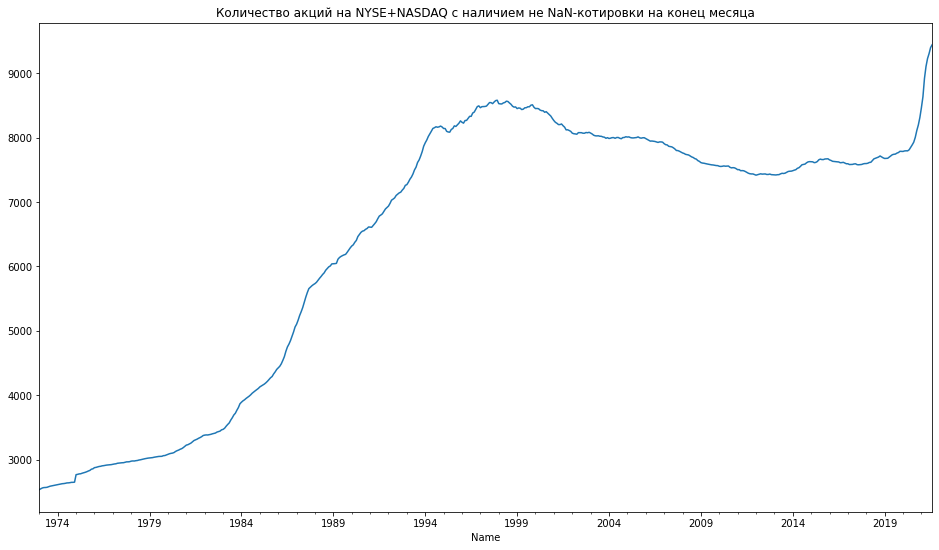

In [51]:
prices.count(axis=1).plot()
plt.title("Количество акций на NYSE+NASDAQ с наличием не NaN-котировки на конец месяца")

Дальше повторяем все те же действия до формирования портфелей. В качестве бенчмарка - SP500

,Winners,Neutral 1,Neutral 2,Losers
"Monthly Mean Return, %",8.70*** (3.95),10.91*** (4.47),11.17*** (4.57),12.30*** (5.62)
"CAGR, %",7.77,9.86,10.14,11.72
"Monthly Volatility, %",15.36,16.99,17.04,15.25
"Sharpe Ratio, %",0.57,0.64,0.66,0.81
"Total Return, %",3694.88,9555.86,10822.21,21654.77
"Alpha, %",-0.02 (-0.07),2.30** (2.01),3.22** (2.25),5.83*** (3.92)
Beta,1.00,0.98,0.91,0.74
Benchmark Correlation,0.99,0.89,0.82,0.74
"Mean Turnover, %",115.92,615.38,711.08,628.00
"Win Rate, %",60.89,61.41,61.75,64.32


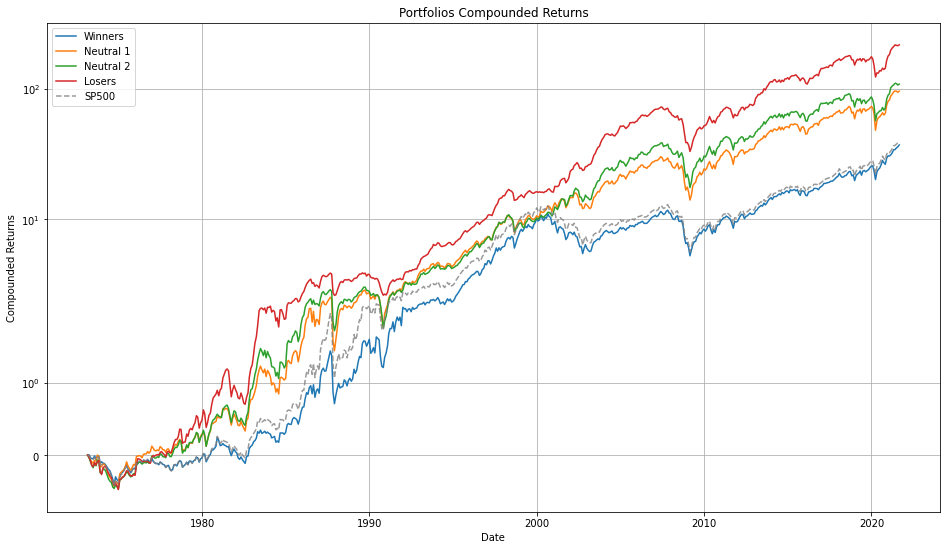

In [58]:
prices, pe, mcap, volume = pqr.utils.replace_with_nan(prices, pe, mcap, volume, to_replace=0)
prices, pe, mcap, volume = pqr.utils.align(prices, pe, mcap, volume) 

us_universe = prices > 2

returns_calculator = pqr.utils.partial(
    pqr.calculate_returns, 
    universe_returns=pqr.prices_to_returns(prices),
)

sp500 = pd.read_excel('C:/Users/tomtosov/Desktop/sp500.xlsx', index_col=0, parse_dates=True)['S&P 500 COMPOSITE - PRICE INDEX']

sp500_benchmark = pqr.Benchmark.from_index(
    index=sp500,
    name='SP500'
)

us_table = pqr.metrics.Table()

us_table.add_metric(
    pqr.utils.partial(
        pqr.metrics.mean_return,
        statistics=True,
        annualizer=12,
    ),
    multiplier=100,
    name="Monthly Mean Return, %",
)

us_table.add_metric(
    pqr.utils.partial(
        pqr.metrics.cagr,
        annualizer=12,
    ),
    multiplier=100,
    name="CAGR, %",
)

us_table.add_metric(
    pqr.utils.partial(
        pqr.metrics.volatility,
        annualizer=12,
    ),
    multiplier=100,
    name="Monthly Volatility, %",
)

us_table.add_metric(
    pqr.utils.partial(
        pqr.metrics.sharpe_ratio,
        annualizer=12,
    ),
    name="Sharpe Ratio, %",
)

us_table.add_metric(
    pqr.utils.partial(
        pqr.metrics.total_return,
    ),
    multiplier=100,
    name="Total Return, %",
)

us_table.add_metric(
    pqr.utils.partial(
        pqr.metrics.alpha,
        statistics=True,
        benchmark=sp500_benchmark,
        annualizer=12,
    ),
    multiplier=100,
    name="Alpha, %",
)

us_table.add_metric(
    pqr.utils.partial(
        pqr.metrics.beta,
        benchmark=sp500_benchmark,
    ),
    name="Beta",
)

us_table.add_metric(
    pqr.utils.partial(
        pqr.metrics.benchmark_correlation,
        benchmark=sp500_benchmark,
    ),
    name="Benchmark Correlation",
)

us_table.add_metric(
    pqr.utils.partial(
        pqr.metrics.mean_turnover,
        annualizer=12,
    ),
    multiplier=100,
    name="Mean Turnover, %",
)

us_table.add_metric(
    pqr.utils.partial(
        pqr.metrics.win_rate,
    ),
    multiplier=100,
    name="Win Rate, %",
)
    
us_table.add_metric(
    pqr.utils.partial(
        pqr.metrics.max_drawdown,
    ),
    multiplier=100,
    name="Max Drawdown, %",
)

us_fig = pqr.metrics.Figure(
    pqr.metrics.compounded_returns,
    name="Compounded Returns",
    benchmark=sp500_benchmark,
    log_scale=True,
)

us_summary = pqr.metrics.Dashboard([us_table, us_fig])

static_params = pqr.utils.compose(
    pqr.utils.partial(pqr.factors.filter, universe=us_universe), 
    pqr.utils.partial(pqr.factors.look_back_mean, period=0),
    pqr.utils.partial(pqr.factors.lag, period=1),
    pqr.utils.partial(pqr.factors.hold, period=1), 
)

us_size_factor = static_params(mcap)
us_volume_factor = static_params(volume)

us_volume_portfolios_usa = pqr.factors.backtest_factor_portfolios(
    factor=us_volume_factor, 
    strategies=pqr.factors.split_quantiles(4, better='more'), 
    allocator=pqr.utils.compose(
        pqr.utils.partial( 
            pqr.normalized_weights, 
            base_weights=us_size_factor 
        ),
    ),        
    calculator=returns_calculator, 
    add_wml=False, 
)

us_summary.display(us_volume_portfolios_usa)

,Winners,Neutral 1,Neutral 2,Losers
"Monthly Mean Return, %",8.38*** (4.02),9.82*** (4.23),11.56*** (4.63),11.02*** (5.25)
"CAGR, %",7.57,8.83,10.59,10.42
"Monthly Volatility, %",14.53,16.17,17.43,14.64
"Sharpe Ratio, %",0.58,0.61,0.66,0.75
"Total Return, %",3361.03,6005.14,13224.73,12254.76
"Alpha, %",0.15 (0.53),2.01 (1.59),4.63** (2.54),5.61*** (3.45)
Beta,0.94,0.89,0.79,0.62
Benchmark Correlation,0.99,0.84,0.70,0.65
"Mean Turnover, %",78.64,218.43,249.35,235.64
"Win Rate, %",61.41,60.21,60.55,62.44


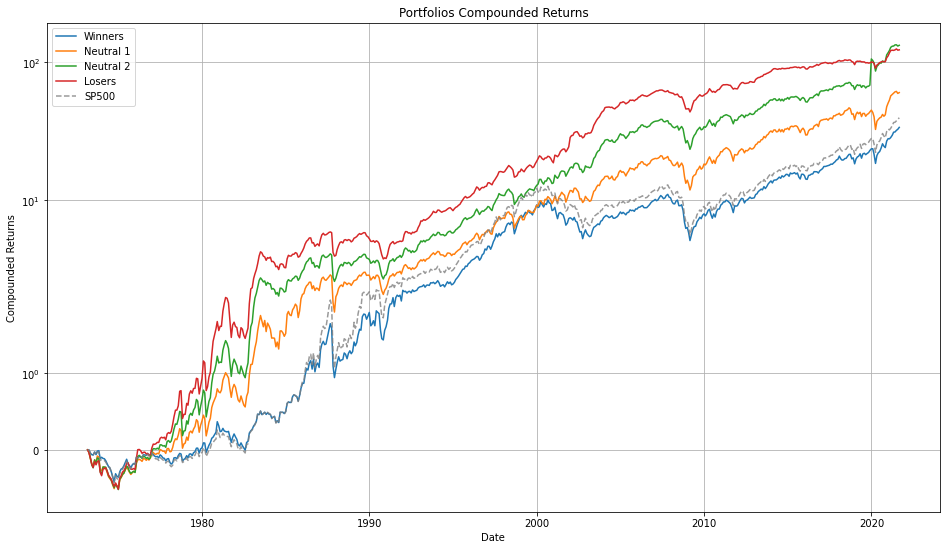

In [60]:
us_size_portfolios_usa = pqr.factors.backtest_factor_portfolios(
    factor=us_size_factor, 
    strategies=pqr.factors.split_quantiles(4, better='more'),
    allocator=pqr.utils.compose(
        pqr.utils.partial( 
            pqr.normalized_weights, 
            base_weights=us_size_factor 
        ),
    ),        
    calculator=returns_calculator, 
    add_wml=False,
)

us_summary.display(us_size_portfolios_usa)

0.9


<AxesSubplot:xlabel='Winners'>

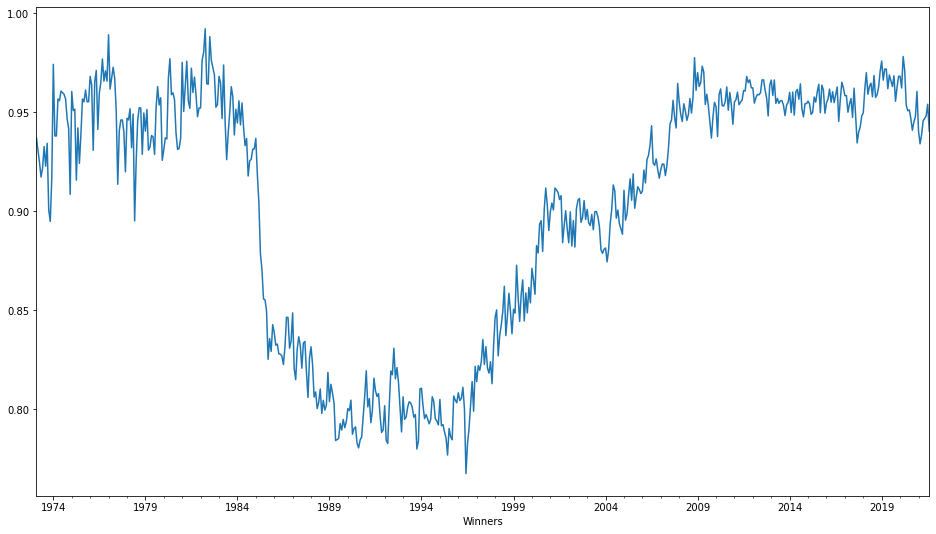

In [61]:
high_volume = us_volume_portfolios_usa[0].holdings.copy()
high_volume[high_volume>0] = 1

high_mcap = us_size_portfolios_usa[0].holdings.copy()
high_mcap[high_mcap>0] = 1

high_intersections = high_volume + high_mcap
high_intersections[high_intersections<2] = 0
high_intersections[high_intersections==2] = 1
high_intersections_share = high_intersections.sum(axis=1) / (us_volume_portfolios_usa[0].holdings >0).sum(axis=1)
print(round(high_intersections_share.mean(), 2))
high_intersections_share.plot()

0.56


<AxesSubplot:xlabel='Losers'>

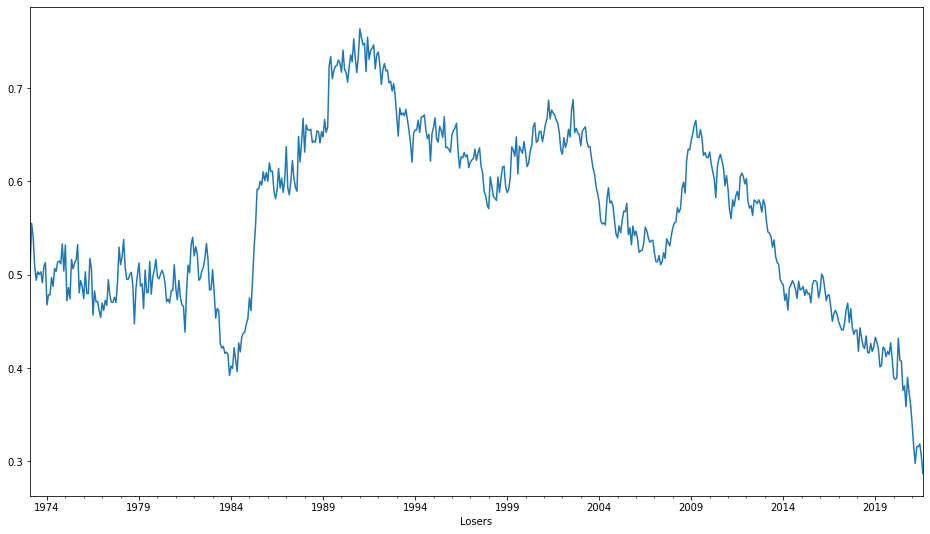

In [65]:
low_volume = us_volume_portfolios_usa[-1].holdings.copy()
low_volume[low_volume>0] = 1

low_mcap = us_size_portfolios_usa[-1].holdings.copy()
low_mcap[low_mcap>0] = 1

low_intersections = low_volume + low_mcap
low_intersections[low_intersections<2] = 0
low_intersections[low_intersections==2] = 1
low_intersections_share = low_intersections.sum(axis=1) / (us_volume_portfolios_usa[-1].holdings >0).sum(axis=1)
print(round(low_intersections_share.mean(), 2))
low_intersections_share.plot()

# 9 - Выводы

1) В США 25% самых дорогих компаний хорошо отражают ликвидность. Позиции в портфелях совпадают с 25% наиболее активно торгуемыми бумагами на 90%. В России пересечение аналогичных портфелей всего 73%, т.е. у четверти бумаг есть рассинхронизация в ликвдность-стоимость.

2) 25% наиболее дешевых компаний для обеих стран почти одинаково пересекаются с наименее ликвидными акциями на 50%.

3) Премия за риск низкой капитализации присутствует на обоих рынках. Менее ликвидные акции в США имеют также существенную премию почти в 4% годовых. Это неудивительно, ведь портфели с size во многом совпадают. Для России обратная ситуация - неликвидные акции одновременно более рискованные и почти на 3% в год менее прибыльные.